In [1]:
using Plots
using LinearAlgebra
using Random
using Luxor

# Analysis
using GLM
using DataFrames
using StatsPlots
using StatsBase

# DEBUG
using Dates 
using Profile

In [2]:
function VDisjointOrganization(x_cord, y_cord, partition_height)
    partition_index = y_cord .>= partition_height
    
    HA_coordinates = [x_cord[partition_index] y_cord[partition_index]]
    NA_coordinates = [x_cord[.!partition_index] y_cord[.!partition_index]]
    
    return HA_coordinates, NA_coordinates
end

function RandomOrganization(x_cord, y_cord)
    rand_index = rand(size(x_cord, 1)) .<= 0.5
    
    # Filter out NA and HA
    HA_coordinates = [x_cord[rand_index] y_cord[rand_index]]
    NA_coordinates = [x_cord[.!rand_index] y_cord[.!rand_index]]
    return HA_coordinates, NA_coordinates
end

function MixingOrganization(x_cord, y_cord, height_max, height_min)
    uplim_index = y_cord .>= height_max
    downlim_index = y_cord .<= height_min
    
    HA_coordinates = [x_cord[uplim_index] y_cord[uplim_index]]
    NA_coordinates = [x_cord[downlim_index] y_cord[downlim_index]]

    k = (.!uplim_index) .&& (.!downlim_index)
    
    rest = [x_cord[k] y_cord[k]]
    rand_index = rand(size(rest, 1)) .<= 0.5
    HA_coordinates = vcat(HA_coordinates, rest[rand_index, :])
    NA_coordinates = vcat(NA_coordinates, rest[.!rand_index, :])
    return HA_coordinates, NA_coordinates
end

function RandomInhibitions(x_cord, y_cord, nHAInhibitions, nNAInhibitions, viral_length)
    
    HA_coordinates, NA_coordinates = VDisjointOrganization(x_cord, y_cord, -2 * viral_length / 5)
    # HA_coordinates, NA_coordinates = RandomOrganization(x_cord, y_cord)
    # HA_coordinates, NA_coordinates = MixingOrganization(x_cord, y_cord, 0, -2 * viral_length / 5)
    
    nHAInhibitions_index = randperm(size(HA_coordinates, 1))[1:nHAInhibitions]
    nNAInhibitions_index = randperm(size(NA_coordinates, 1))[1:nNAInhibitions]

    HA_coordinates = hcat(HA_coordinates, zeros(Int, size(HA_coordinates, 1), 1)) # Add a column which keep track of the number of binds
    HA_coordinates = hcat(HA_coordinates, fill(Working, size(HA_coordinates, 1))) # Add a column which keep track of the working state of ligands
    
    NA_coordinates = hcat(NA_coordinates, zeros(Int, size(NA_coordinates, 1), 1)) # Add a column which keep track of the number of binds
    NA_coordinates = hcat(NA_coordinates, fill(Working, size(NA_coordinates, 1))) # Add a column which keep track of the working state of ligands

    HA_coordinates[nHAInhibitions_index, 4] .= Blocked
    NA_coordinates[nNAInhibitions_index, 4] .= Blocked
    
    return HA_coordinates, NA_coordinates
end

RandomInhibitions (generic function with 1 method)

In [3]:
function IAV_organization(viral_length, binding_radius)                                                 
    # ==============================================================================================================
    # IAV_organization(viral_length,binding_radius): specifies the x-y coordinates of HA and NA on the surface of an 
    # IAV viral particle.
    #     viral_length: length of the virus's main axis [m]
    #     binding_radius: distance between adjacent molecules [m]
    # Returns a set of HA coordinates, NA coordinates, and the corners of a rectangle which defines the maximum 
    # bounding rectangle of the IAV particle.
    # ==========================================================================
    
    # Calculating vertical heights
    height = sqrt(3) * binding_radius / 2
    height_twice = sqrt(3) * binding_radius

    height_max = viral_length / 2
    height_min = -viral_length / 2

    # Calculating y coordinates
    y0 = collect(height_min:height_twice:height_max)
    y1 = collect(height_min:height_twice:(height_max + height_twice))
    y2 = collect((height_min - height_twice):height_twice:(height_max + height_twice))

    # Calculating x coordinates
    x0 = zeros(length(y0))
    x1 = zeros(length(y1))
    x2 = zeros(length(y2))

    # Concatenating coordinates
    y_cord = vcat(y0, y1 .- height, y2, y1 .- height, y2, y1 .- height, y2, y1 .- height, y0)
    x_cord = vcat(x0 .- 2*binding_radius, x1 .- 3*binding_radius/2, x2 .- binding_radius, x1 .- binding_radius/2, x2, x1 .+ binding_radius/2, x2 .+ binding_radius, x1 .+ 3*binding_radius/2, x0 .+ 2*binding_radius)

    # Calculating corners of the bounding rectangle
    IAV_binding_rectangle_corners = [minimum(x_cord)-binding_radius maximum(y_cord)+binding_radius;
               maximum(x_cord)+binding_radius maximum(y_cord)+binding_radius;
               maximum(x_cord)+binding_radius minimum(y_cord)-binding_radius;
               minimum(x_cord)-binding_radius minimum(y_cord)-binding_radius]

    HA_coordinates, NA_coordinates = RandomInhibitions(x_cord, y_cord, 10, 10, viral_length)
    
    return HA_coordinates, NA_coordinates, IAV_binding_rectangle_corners
end

IAV_organization (generic function with 1 method)

In [4]:
function plotIAV()
    p = plot(Boundary_rectangle_corners_plot[:, 1], Boundary_rectangle_corners_plot[:, 2], marker=(:dot, 4), color="black", label="Boundary", grid=true, aspect_ratio=:equal, legend=true, loc="right", horiz=true)
    plot!(IAV_binding_rectangle_corners_plot[:, 1], IAV_binding_rectangle_corners_plot[:, 2], marker=(:dot, 4), color="black", label="BindingRadius")
    scatter!(HA_coordinates[:, 1], HA_coordinates[:, 2], markersize=6, color="lightblue", markerstrokewidth=0.5, label="HA")
    scatter!(NA_coordinates[:, 1], NA_coordinates[:, 2], markersize=6, color="lightgreen", markerstrokewidth=0.5, label="NA")

    block_index = HA_coordinates[:, 4] .== Blocked
    scatter!(HA_coordinates[block_index, 1], HA_coordinates[block_index, 2], markersize=6, color="red", markerstrokewidth=0.5, label="Disabled HA")
    block_index = NA_coordinates[:, 4] .== Blocked
    scatter!(NA_coordinates[block_index, 1], NA_coordinates[block_index, 2], markersize=6, color="red", markerstrokewidth=0.5, label="Disabled NA")
    
    xlabel!("X-axis")
    ylabel!("Y-axis")
    title!("Plot of IAV organizations")
    plot!(size=(1920,1080))
    # display(p)
    return p
end

function plotIAV_SA_Bond()
    particles_free, particles_HA, particles_NA = FilterParticlesbyBindingLigand(Particles_coordinates)
    CleavedSA_coordinates, CarpetSA_coordinates, FloatingAntibody_coordinates = FilterParticlesbyNature(particles_free)
    CarpetSA_coordinates_inRect, CarpetSA_coordinates_outRect = FilterParticlesbyRect(CarpetSA_coordinates, IAV_binding_rectangle_corners)
    FloatingAntibody_coordinates_inRect, FloatingAntibody_coordinates_outRect = FilterParticlesbyRect(FloatingAntibody_coordinates, IAV_binding_rectangle_corners)
    
    _, CarpetSA_HA, FloatingAntibody_HA = FilterParticlesbyNature(particles_HA)
    _, CarpetSA_NA, FloatingAntibody_NA = FilterParticlesbyNature(particles_NA)
    
    p = plot(Boundary_rectangle_corners_plot[:, 1], Boundary_rectangle_corners_plot[:, 2], marker=(:dot, 4), color="black", label="Boundary", grid=true, aspect_ratio=:equal, legend=true, loc="right", horiz=true)
    plot!(IAV_binding_rectangle_corners_plot[:, 1], IAV_binding_rectangle_corners_plot[:, 2], marker=(:dot, 4), color="black", label="BindingRadius")
    scatter!(HA_coordinates[:, 1], HA_coordinates[:, 2], markersize=6, color="lightblue", markerstrokewidth=0.5, label="HA")
    scatter!(NA_coordinates[:, 1], NA_coordinates[:, 2], markersize=6, color="lightgreen", markerstrokewidth=0.5, label="NA")
    # Plot disabled ligand
    scatter!(FloatingAntibody_HA[:, 5], FloatingAntibody_HA[:, 6], markersize=6, color="red", markerstrokewidth=0.5, label="Disabled HA")
    scatter!(FloatingAntibody_NA[:, 5], FloatingAntibody_NA[:, 6], markersize=6, color="red", markerstrokewidth=0.5, label="Disabled NA")
    
    scatter!(CleavedSA_coordinates[:, 2], CleavedSA_coordinates[:, 3], markersize=3, color="red", markerstrokecolor="red", label="CleavedSA")
    scatter!(CarpetSA_coordinates_outRect[:, 2], CarpetSA_coordinates_outRect[:, 3], markersize=4, color="orange", markerstrokecolor="orange", label="CarpetSA_outRect")
    scatter!(CarpetSA_coordinates_inRect[:, 2], CarpetSA_coordinates_inRect[:, 3], markersize=4, color="orange", markerstrokewidth=0.2, label="CarpetSA_inRect")
    scatter!(FloatingAntibody_coordinates_outRect[:, 2], FloatingAntibody_coordinates_outRect[:, 3], markersize=4, color="brown", markerstrokecolor="brown", label="FloatingAntibody_outRect")
    scatter!(FloatingAntibody_coordinates_inRect[:, 2], FloatingAntibody_coordinates_inRect[:, 3], markersize=4, color="brown", markerstrokewidth=0.2, label="FloatingAntibody_inRect")
    scatter!(CarpetSA_HA[:, 2], CarpetSA_HA[:, 3], markersize=4, color="orange", markerstrokewidth=0.2, shape=:utriangle, label="")
    scatter!(CarpetSA_NA[:, 2], CarpetSA_NA[:, 3], markersize=4, color="orange", markerstrokewidth=0.2, shape=:utriangle, label="")
    scatter!(FloatingAntibody_HA[:, 2], FloatingAntibody_HA[:, 3], markersize=4, color="brown", markerstrokewidth=0.2, shape=:utriangle, label="")
    scatter!(FloatingAntibody_NA[:, 2], FloatingAntibody_NA[:, 3], markersize=4, color="brown", markerstrokewidth=0.2, shape=:utriangle, label="")

    block_index = HA_coordinates[:, 4] .== Blocked
    scatter!(HA_coordinates[block_index, 1], HA_coordinates[block_index, 2], markersize=6, color="red", markerstrokewidth=0.5, label="Disabled HA")
    block_index = NA_coordinates[:, 4] .== Blocked
    scatter!(NA_coordinates[block_index, 1], NA_coordinates[block_index, 2], markersize=6, color="red", markerstrokewidth=0.5, label="Disabled NA")

    if !isempty(CarpetSA_HA)
        # plot!([(CarpetSA_HA[1, 2], CarpetSA_HA[1, 3]), (CarpetSA_HA[1, 5], CarpetSA_HA[1, 6])], line=(:yellow, 2), label="CarpetSA_HA Bond")
        for pair in eachrow(CarpetSA_HA)
            plot!([(pair[2], pair[3]), (pair[5], pair[6])], line=(:yellow, 2), label="")
        end
    end# cyan, lightgreen

    if !isempty(FloatingAntibody_HA)
        # plot!([(FloatingAntibody_HA[1, 2], FloatingAntibody_HA[1, 3]), (FloatingAntibody_HA[1, 5], FloatingAntibody_HA[1, 6])], line=(:yellow, 2), label="FloatingAntibody_HA Bond")
        for pair in eachrow(FloatingAntibody_HA)
            plot!([(pair[2], pair[3]), (pair[5], pair[6])], line=(:yellow, 2), label="")
        end
    end
    
    if !isempty(CarpetSA_NA)
        # plot!([(CarpetSA_HA[1, 2], CarpetSA_HA[1, 3]), (CarpetSA_HA[1, 5], CarpetSA_HA[1, 6])], line=(:yellow, 2), label="CarpetSA_HA Bond")
        for pair in eachrow(CarpetSA_NA)
            plot!([(pair[2], pair[3]), (pair[5], pair[6])], line=(:yellow, 2), label="")
        end
    end# cyan, lightgreen

    if !isempty(FloatingAntibody_NA)
        # plot!([(FloatingAntibody_HA[1, 2], FloatingAntibody_HA[1, 3]), (FloatingAntibody_HA[1, 5], FloatingAntibody_HA[1, 6])], line=(:yellow, 2), label="FloatingAntibody_HA Bond")
        for pair in eachrow(FloatingAntibody_NA)
            plot!([(pair[2], pair[3]), (pair[5], pair[6])], line=(:yellow, 2), label="")
        end
    end
    
    xlabel!("X-axis")
    ylabel!("Y-axis")
    title!("Plot of IAV inside SA with bond")
    plot!(size=(1920,1080))
    # display(p)
    return p
end

plotIAV_SA_Bond (generic function with 1 method)

In [5]:
function Shuffle(coordinates::Matrix{Any})
    row_indices = 1:size(coordinates, 1)
    shuffled_indices = Random.shuffle(row_indices)
    coordinates = coordinates[shuffled_indices, :]
    return coordinates
end

function FilterParticlesbyNature(coordinates::Matrix{Any})
    CleavedSA_coordinates = coordinates[coordinates[:, 1] .== CleavedSA, :]
    CarpetSA_coordinates = coordinates[coordinates[:, 1] .== CarpetSA, :]
    FloatingAntibody_coordinates = coordinates[coordinates[:, 1] .== FloatingAntibody, :]
    return CleavedSA_coordinates, CarpetSA_coordinates, FloatingAntibody_coordinates
end

function FilterParticlesbyRect(coordinates::Matrix{Any}, rectangle_corners::Matrix{Float64})
    polygon = Luxor.Point.(rectangle_corners[:, 1], rectangle_corners[:, 2])
    points = Luxor.Point.(coordinates[:, 2], coordinates[:, 3])
    inside = [isinside(p, polygon; allowonedge=true) for p in points]
    Particles_coordinates_inRect = coordinates[inside, :]
    Particles_coordinates_outRect = coordinates[.!inside, :]
    return Particles_coordinates_inRect, Particles_coordinates_outRect
end


function FilterParticlesbyBindingLigand(coordinates::Matrix{Any})
    Particles_Free = coordinates[coordinates[:, 4] .== Null, :]
    Particles_HA = coordinates[coordinates[:, 4] .== HA, :]
    Particles_NA = coordinates[coordinates[:, 4] .== NA, :]
    return Particles_Free, Particles_HA, Particles_NA
end

function BindingPickedParticles(Ligand, coordinates::Matrix{Any}, Type)
    _, CarpetSAs, FloatingAntibodies = FilterParticlesbyNature(coordinates)

    if size(FloatingAntibodies, 1) == 0
        Particles_Free_inRect_inRadius_bind = coordinates
        Particles_Free_inRect_inRadius_bind
        Particles_Free_inRect_inRadius_bind[:, 4:6] .= [Type Ligand[1] Ligand[2]]
        Particles_Free_inRect_inRadius_bind
                                
        Ligand[3] = Ligand[3] + size(Particles_Free_inRect_inRadius_bind,1)
    else
        particles_free_inRect_inRadius_bind_antibody_index = randperm(size(FloatingAntibodies, 1))[1:1]
        particles_free_inRect_inRadius_bind_antibody = FloatingAntibodies[particles_free_inRect_inRadius_bind_antibody_index, :]
        particles_free_inRect_inRadius_not_bind_antibody_index = setdiff(1:size(FloatingAntibodies, 1), particles_free_inRect_inRadius_bind_antibody_index)
        particles_free_inRect_inRadius_not_bind_antibody = FloatingAntibodies[particles_free_inRect_inRadius_not_bind_antibody_index, :]
        
        particles_free_inRect_inRadius_bind_antibody                    
        particles_free_inRect_inRadius_bind_antibody[:, 4:6] .= [Type Ligand[1] Ligand[2]]
        particles_free_inRect_inRadius_bind_antibody
     
        Ligand[3] = 0
        Ligand[4] = Blocked
                                
        Particles_Free_inRect_inRadius_bind = vcat(CarpetSAs, particles_free_inRect_inRadius_not_bind_antibody, particles_free_inRect_inRadius_bind_antibody)
    end
    return Particles_Free_inRect_inRadius_bind
end

function BindingGroup(Ligands_coordinates::Matrix{Any}, coordinates::Matrix{Any}, max_bond::Int, Type)
    # Generate a new Particles_Free_inRect
    for Ligand in eachrow(Ligands_coordinates)
        # @show Ligand
        if Ligand[4] != Blocked
            n = Int(max_bond - Ligand[3])
            if n > 0
                # Computing distance and filtering out particles within the binding radius of the ligand
                Particles_Free_inRect_inRadius_index = (sqrt.((coordinates[:, 2] .- Ligand[1]).^2 .+ (coordinates[:, 3] .- Ligand[2]).^2)) .<= r
                # @show sum(Particles_Free_inRect_inRadius_index)
                
                Particles_Free_inRect_inRadius = coordinates[Particles_Free_inRect_inRadius_index, :]
                Particles_Free_inRect_outRadius = coordinates[.!Particles_Free_inRect_inRadius_index, :]

                if size(Particles_Free_inRect_inRadius, 1) != 0
                    # Picking possible binding particles by pon
                    Particles_Free_inRect_inRadius_possible_bind_index = rand(size(Particles_Free_inRect_inRadius, 1)) .< pon
                    Particles_Free_inRect_inRadius_possible_bind = Particles_Free_inRect_inRadius[Particles_Free_inRect_inRadius_possible_bind_index, :]
                    Particles_Free_inRect_inRadius_not_bind = Particles_Free_inRect_inRadius[.!Particles_Free_inRect_inRadius_possible_bind_index, :]

                    if size(Particles_Free_inRect_inRadius_possible_bind, 1) != 0
                        # If too many candidate
                        if size(Particles_Free_inRect_inRadius_possible_bind, 1) > n
                            # Picking max n SA for bind
                            Particles_Free_inRect_inRadius_pick_bind_index = randperm(size(Particles_Free_inRect_inRadius_possible_bind, 1))[1:n]
                            Particles_Free_inRect_inRadius_pick_bind = Particles_Free_inRect_inRadius_possible_bind[Particles_Free_inRect_inRadius_pick_bind_index, :]
                            Particles_Free_inRect_inRadius_not_pick_bind_index = setdiff(1:size(Particles_Free_inRect_inRadius_possible_bind, 1), Particles_Free_inRect_inRadius_pick_bind_index)
                            Particles_Free_inRect_inRadius_not_pick_bind = Particles_Free_inRect_inRadius_possible_bind[Particles_Free_inRect_inRadius_not_pick_bind_index, :]

                            Particles_Free_inRect_inRadius_bind = BindingPickedParticles(Ligand, Particles_Free_inRect_inRadius_pick_bind, Type)
                            coordinates = vcat(Particles_Free_inRect_outRadius, Particles_Free_inRect_inRadius_not_bind, Particles_Free_inRect_inRadius_bind)              
                        else # If too less candidate
                            Particles_Free_inRect_inRadius_bind = BindingPickedParticles(Ligand, Particles_Free_inRect_inRadius_possible_bind, Type)
                            coordinates = vcat(Particles_Free_inRect_outRadius, Particles_Free_inRect_inRadius_not_bind, Particles_Free_inRect_inRadius_bind)                                
                        end
                    end
                end
            end
        end
    end
    return coordinates
end

# Partitions are inclusive for top left bottom right
# topLeft    | top    | topLeft
# ----------------------------------
# left       | center | right
# ----------------------------------
# bottomLeft | bottom | bottomRight
function FilterParticlesbyOutOfBoundaryDirection(coordinates::Matrix{Any})
    top = coordinates[(coordinates[:, 2] .>= -Lmax) .& (coordinates[:, 2] .<= Lmax) .& (coordinates[:, 3] .>= Lmax), :]
    bottom = coordinates[(coordinates[:, 2] .>= -Lmax) .& (coordinates[:, 2] .<= Lmax) .& (coordinates[:, 3] .<= -Lmax), :]
    left = coordinates[(coordinates[:, 3] .>= -Lmax) .& (coordinates[:, 3] .<= Lmax) .& (coordinates[:, 2] .<= -Lmax), :]
    right = coordinates[(coordinates[:, 3] .>= -Lmax) .& (coordinates[:, 3] .<= Lmax) .& (coordinates[:, 2] .>= Lmax), :]
    topLeft = coordinates[(coordinates[:, 2] .< -Lmax) .& (coordinates[:, 3] .> Lmax), :]
    topRight = coordinates[(coordinates[:, 2] .> Lmax) .& (coordinates[:, 3] .> Lmax), :]
    bottomLeft = coordinates[(coordinates[:, 2] .< -Lmax) .& (coordinates[:, 3] .< -Lmax), :]
    bottomRight = coordinates[(coordinates[:, 2] .> Lmax) .& (coordinates[:, 3] .< -Lmax), :]
    return top, bottom, left, right, topLeft, topRight, bottomLeft, bottomRight
end

function PeriodicBoundary(coordinates::Matrix{Any})
    coordinates_inRect, coordinates_outRect = FilterParticlesbyRect(coordinates, Boundary_rectangle_corners)

    top, bottom, left, right, topLeft, topRight, bottomLeft, bottomRight = FilterParticlesbyOutOfBoundaryDirection(coordinates_outRect)
    top[:, 3] = top[:, 3] .- Lmax
    bottom[:, 3] = bottom[:, 3] .+ Lmax
    left[:, 2] = left[:, 2] .+ Lmax
    right[:, 2] = right[:, 2] .- Lmax
    topLeft[:, 2] = topLeft[:, 2] .+ Lmax
    topLeft[:, 3] = topLeft[:, 3] .- Lmax
    topRight[:, 2] = topRight[:, 2] .- Lmax
    topRight[:, 3] = topRight[:, 3] .- Lmax
    bottomLeft[:, 2] = bottomLeft[:, 2] .+ Lmax
    bottomLeft[:, 3] = bottomLeft[:, 3] .+ Lmax
    bottomRight[:, 2] = bottomRight[:, 2] .- Lmax
    bottomRight[:, 3] = bottomRight[:, 3] .+ Lmax
    
    return vcat(coordinates_inRect, top, bottom, left, right, topLeft, topRight, bottomLeft, bottomRight)
end

function rotation(coordinates, rotationMatrix::Matrix{Float64})
    new_coordinates = copy(coordinates)
    for row in 1:size(coordinates, 1)
        new_coordinates[row, 1:2] = rotationMatrix * coordinates[row, 1:2]
    end
    return new_coordinates
end

function translation(coordinates, translationVector::Vector{Float64})
    new_coordinates = copy(coordinates)
    for row in 1:size(coordinates, 1)
        new_coordinates[row, 1:2] = coordinates[row, 1:2] + translationVector
    end
    return new_coordinates
end

function applyMovements(coordinates, movement::Vector{Float64})
    # Creates a 2x2 rotation matrix based on the delta_theta
    rotationMatrix = [cos(movement[3]) sin(movement[3]); -sin(movement[3]) cos(movement[3])]
    translationVector = movement[1:2]
    
    # Apply rotation and then translate based on change vector
    new_coordinates = rotation(coordinates, rotationMatrix)
    new_coordinates = translation(new_coordinates, translationVector)
    
    return new_coordinates
end

applyMovements (generic function with 1 method)

In [6]:
# Warning: revision inplace
function UpdateBondNumber()
    _, Particles_HA, Particles_NA = FilterParticlesbyBindingLigand(Particles_coordinates)
    for LigandRow in eachrow(HA_coordinates)
        LigandRow[3] = 0
        for ParticleRow in eachrow(Particles_HA)
            if LigandRow[1] == ParticleRow[5] && LigandRow[2] == ParticleRow[6]
                LigandRow[3] = LigandRow[3] + 1
            end
        end
    end
    for LigandRow in eachrow(NA_coordinates)
        LigandRow[3] = 0
        for ParticleRow in eachrow(Particles_NA)
            if LigandRow[1] == ParticleRow[5] && LigandRow[2] == ParticleRow[6]
                LigandRow[3] = LigandRow[3] + 1
            end
        end
    end
end

# Warning: revision inplace
function Binding()
    Particles_Free, Particles_HA, Particles_NA = FilterParticlesbyBindingLigand(Particles_coordinates)
    Particles_Free_inRect, Particles_Free_outRect = FilterParticlesbyRect(Particles_Free, IAV_binding_rectangle_corners) # Partition the SA by IAV_binding_rectangle_corners to reduce computing time
    
    UpdateBondNumber()
    
    if rand() <= 0.5
        Particles_Free_inRect = BindingGroup(HA_coordinates, Particles_Free_inRect, MAX_HA_BOND, HA)
        bond_free, HA_bond, NA_bond = FilterParticlesbyBindingLigand(Particles_Free_inRect)
        Particles_Free_inRect = BindingGroup(NA_coordinates, bond_free, MAX_NA_BOND, NA)
    else 
        Particles_Free_inRect = BindingGroup(NA_coordinates, Particles_Free_inRect, MAX_NA_BOND, NA)
        bond_free, HA_bond, NA_bond = FilterParticlesbyBindingLigand(Particles_Free_inRect)
        Particles_Free_inRect = BindingGroup(HA_coordinates, bond_free, MAX_HA_BOND, HA)
    end
    global Particles_coordinates = vcat(HA_bond, NA_bond, Particles_Free_inRect, Particles_Free_outRect, Particles_HA, Particles_NA)
end

# Warning: revision in place
function SimpleRandomDiffusion()    
    Particles_Free, Particles_HA, Particles_NA = FilterParticlesbyBindingLigand(Particles_coordinates)
    _, CarpetSA, FloatingAntibody = FilterParticlesbyNature(Particles_Free)

    random_sign_index = rand(size(FloatingAntibody, 1)) .>= 0.5
    random_sign = rand(size(FloatingAntibody, 1))
    random_sign[random_sign_index] .= 1
    random_sign[.!random_sign_index] .= -1
    random_swap_index = rand(size(FloatingAntibody, 1)) .<= 0.5
            
    dx = 2 * ds * rand(size(FloatingAntibody, 1)) .- ds
    dy = random_sign .* sqrt.(ds.^2 .- dx.^2)
    
    dx_rand = copy(dx)
    dx_rand[random_swap_index, 1] = dy[random_swap_index, 1]
    dy_rand = copy(dy)
    dy_rand[random_swap_index, 1] = dx[random_swap_index, 1]

    FloatingAntibody[:, 2] = FloatingAntibody[:, 2] .+ dx_rand
    FloatingAntibody[:, 3] = FloatingAntibody[:, 3] .+ dy_rand
    
    FloatingAntibody = PeriodicBoundary(FloatingAntibody)
    
    global Particles_coordinates = vcat(FloatingAntibody, CarpetSA, Particles_HA, Particles_NA)
end

# # Warning: revision in place
# Move IAV randomly and break all bind. 
function SimpleRandomMovementSubjectToBreakedBondRatio()
    Particles_Free, Particles_HA, Particles_NA = FilterParticlesbyBindingLigand(Particles_coordinates)
    Particles_Ligands = vcat(Particles_HA, Particles_NA)
    _, CarpetSA_Ligands, FloatingAntibody_Ligands = FilterParticlesbyNature(Particles_Ligands)

    new_movement = Vector{Float64}(undef, 3)
    
    alpha = 0.25    # Allowing alpha bond break at most
    trail_rejected = true
    trail_count = 0
    damp_factor_power = 1
    
    while trail_rejected
        Z = 0.01 .* randn(3)
        M11 = mp*cos(dMovement[3])^2 + mt*sin(dMovement[3])^2
        M12 = (mp-mt)*cos(dMovement[3])*sin(dMovement[3])
        M22 = mp*sin(dMovement[3])^2 + mt*cos(dMovement[3])^2
        M = [M22 M12 ; M12 M11]

        new_movement[1:2] = dMovement[1:2] + M * Z[1:2]
        new_movement[3] = dMovement[3] + mw*(Z[3])
        
        if size(CarpetSA_Ligands, 1) != 0
            test_Ligands = copy(CarpetSA_Ligands)
            test_Ligands[:, 5:6] = applyMovements(test_Ligands[:, 5:6], new_movement)
            
            nBondBreaked_index = (sqrt.((test_Ligands[:, 2] .- test_Ligands[:, 5]).^2 .+ (test_Ligands[:, 3] .- test_Ligands[:, 6]).^2)) .> r
            nBondBreaked = sum(nBondBreaked_index)
            
            # need to consider the influence of Antibody, it get moved aroudn with movement and keep binding
            if nBondBreaked <= ceil(size(test_Ligands, 1) * alpha)
                CarpetSA_Ligands[:, 5:6] = applyMovements(CarpetSA_Ligands[:, 5:6], new_movement)
                CarpetSA_Ligands[nBondBreaked_index, 4:6] .= [Null undef undef]
                trail_rejected = false
                println("trail_count = $trail_count")
                break
            else
                trail_count = trail_count + 1
            end
        else
            trail_rejected = false
            break
        end
    end
    
    global dMovement = new_movement
    FloatingAntibody_Ligands[:, 5:6] = applyMovements(FloatingAntibody_Ligands[:, 5:6], dMovement)
    FloatingAntibody_Ligands[:, 2:3] = applyMovements(FloatingAntibody_Ligands[:, 2:3], dMovement)
    global Particles_coordinates = vcat(Particles_Free, CarpetSA_Ligands, FloatingAntibody_Ligands)
    
    global HA_coordinates = applyMovements(HA_coordinates, dMovement)
    global NA_coordinates = applyMovements(NA_coordinates, dMovement)
    global IAV_binding_rectangle_corners = applyMovements(IAV_binding_rectangle_corners, dMovement)
    global IAV_binding_rectangle_corners_plot = vcat(IAV_binding_rectangle_corners, IAV_binding_rectangle_corners[1, :]')
end

# Warning: revision in place
# Debind HA-SA bond by poff, cleave NA-SA bond by pcut, antibody don't get debind or cleaved. 
function DebindAndCleave()
    Particles_Free, Particles_HA, Particles_NA = FilterParticlesbyBindingLigand(Particles_coordinates)
    _, SA_HA, Antibody_HA = FilterParticlesbyNature(Particles_HA)
    _, SA_NA, Antibody_NA = FilterParticlesbyNature(Particles_NA)
    
    if poff <= 1
        SA_HA_off_index = rand(size(SA_HA, 1)) .< poff
        SA_HA[SA_HA_off_index, 4:6] .= [Null undef undef]
    else
        SA_HA[:, 4:6] .= [Null undef undef]
    end
    
    if pcut <= 1
        SA_NA_off_index = rand(size(SA_NA, 1)) .< pcut
        SA_NA[SA_NA_off_index, 1] .= CleavedSA
        SA_NA[SA_NA_off_index, 4:6] .= [Null undef undef]
    else
        SA_NA[:, 1] .= CleavedSA
        SA_NA[:, 4:6] .= [Null undef undef]
    end

    global Particles_coordinates = vcat(Particles_Free, SA_HA, Antibody_HA, SA_NA, Antibody_NA)
end

# Warning: revision in place
function GarbageCollection()
    CleavedSA_coordinates, CarpetSA_coordinates, FloatingAntibody_coordinates = FilterParticlesbyNature(Particles_coordinates)
    global Particles_coordinates = vcat(CarpetSA_coordinates, FloatingAntibody_coordinates)
end

GarbageCollection (generic function with 1 method)

In [7]:
function IAV_diffusion(nSimStep)
    # ==========================================================================
    # IAV_diffusion_mobile_SA(sname): simulates the diffusion
    # of a virus particle on a 2D surface with immobile sialic acid. Periodically
    # displays simulation progress, plotting HA locations (blue dots), NA
    # locations (red dots), sialic acid locations (green dots), and currently
    # bound sialic acid residues (black dots).
    # 
    # Inputs:
    #   sname: file name for saved results
    # Saved variables:
    #   NA_pos: coordinates of NA in the frame of the virus
    #   HA_pos: coordinates of HA in the frame of the virus
    #   P: virus position and orientation (column 1 = x, column 2 = y,
    #   column 3 = theta)
    #   S: sialic acid coordinates
    #   IB: indices of bound sialic acid
    #   Lmax: simulation window size
    #   kon: HA on rate
    #   kcat: NA catalytic rate
    #   koff: HA off rate
    #   t: time (simulation steps)
    # ==========================================================================
    for n in 1:nSimStep
        
        # Shuffle the HA and NA list so that we can sample binding SA in random order
        global HA_coordinates = Shuffle(HA_coordinates)
        global NA_coordinates = Shuffle(NA_coordinates)
        
        # Binding
        Binding()
        # push!(ResultPlots, plotIAV_SA_Bond())

        # Diffusion
        SimpleRandomDiffusion()
        # push!(ResultPlots, plotIAV_SA_Bond())
        
        # Generate random movement subject to binding restriction
        SimpleRandomMovementSubjectToBreakedBondRatio()
        global DMOVEMENT[:, n] = dMovement
        
        # push!(ResultPlots, plotIAV_SA_Bond())
        
        # Cleave and debind SA stochastically
        DebindAndCleave()
        # push!(ResultPlots, plotIAV_SA_Bond())

        # Remove removed SA
        GarbageCollection()
        push!(ResultPlots, plotIAV_SA_Bond())

        current_time = now()
        println("loop $n complete at $current_time")
    end
end

IAV_diffusion (generic function with 1 method)

In [8]:
# Main Function

# Initiation: Mathematics Coefficients =====================================
# All coefficient adapted from Vachy and Fletcher's model [1]:
# Notice: original b has been replaced by r as the binding radius
    
dt = 0.2 # Time step [s]
ds = 1e-9 # SA step size [m]; related to SA diffusion coefficient through get_DSA.m

# Virus length (L), diameter (d), binding radius (r):
L = 0.25e-6; d = 0.1e-6; r = 7.5e-9

# Thermal energy (kT), viscosity (mu), window size (-Lmax to +Lmax)
kT = 1.38e-23 * 300; mu = 1e-3; Lmax = 0.5e-6

# Effective concentration of one SA within binding radius [mol/L]
cL = (1 / 6.02e23) / (1000 * 4/3 * π * r^3)     

# Translational & rotational mobilities, damped as in paper's descriptions
Dx = 0.01 * kT * (log(2 * L / d) - 1/2) / (2 * π * mu * L)
Dy = 0.01 * kT * (log(2 * L / d) + 1/2) / (4 * π * mu * L)
Dtheta = 0.01 * 3 * kT * (log(2 * L / d) - 1/2) / (π * mu * L^3)

kcat = 100      # Catalytic rate of NA (1/s)
kon = 400       # HA on rate (1/(Ms))
koff = 1        # HA off rate (1/s)
pon = kon * cL * dt  # Probability of binding in time step dt (HA-SA)
poff = koff * dt     # Probability of unbinding in time step dt (HA-SA)
pcut = kcat * dt     # Probability of cleaving SA in time step dt

# Mobility coefficients
mp = sqrt(2 * Dx * dt)
mt = sqrt(2 * Dy * dt)
mw = sqrt(2 * Dtheta * dt)
# ==========================================================================
    
# Initiation: Simulation Constant and Variables ============================
Random.seed!(hash("REX2023-2024"))

# Save Result Plots
ResultPlots = Vector{Plots.Plot}()

# Set simulation loop number
nSimStep = 100

# Maximum binding number
MAX_HA_BOND = 3
MAX_NA_BOND = 4
    
# Define movement vector, [delta x, delta y, delta theta]
DMOVEMENT = Matrix{Float64}(undef, 3, nSimStep) # Tracking all movement for analysis
dMovement = Vector{Float64}(undef, 3)
dMovement[:] .= 0.0

# Initialize HA and NA positions along with binding rectangle
# col 1 is ligand's x coordinates
# col 2 is ligand's y coordinates
# col 3 is ligand's current binding numbers
# col 4 is ligand's state (Working or Blocked)
@enum LigandState Blocked=0 Working=1
HA_coordinates, NA_coordinates, IAV_binding_rectangle_corners = IAV_organization(L, 2 * r)

# Add simulation boundaries 
Boundary_rectangle_corners = [-Lmax Lmax; Lmax Lmax; Lmax -Lmax; -Lmax -Lmax]

# For plotting purpose
IAV_binding_rectangle_corners_plot = vcat(IAV_binding_rectangle_corners, IAV_binding_rectangle_corners[1, :]')
Boundary_rectangle_corners_plot = [-Lmax Lmax; Lmax Lmax; Lmax -Lmax; -Lmax -Lmax; -Lmax Lmax]
push!(ResultPlots, plotIAV())    # Save organization as first plot 

# Number of sialic acid at carpet and in suspension
nCarpetSA = 20000
nFloatingAntibody = 100
    
# Initialize SA locations:
# col 1 is the NatureOfParticle enum (Removed or CarpetSA or FloatingAntibody)
# col 2 is SA's x coordinates
# col 3 is SA's y coordinates
# col 4 is the BindingLigand enum (Null or HA or NA)
# col 5 is ligand's x coordinates
# col 6 is ligand's y coordinates
@enum NatureOfParticle CleavedSA=0 CarpetSA=1 FloatingAntibody=2 
@enum BindingLigand Null=0 HA=1 NA=2
Particles_coordinates = hcat(
    vcat(fill(CarpetSA, nCarpetSA), fill(FloatingAntibody, nFloatingAntibody)),
    vcat(2 * Lmax * (rand(nCarpetSA, 2) .- 0.5), 2 * Lmax * (rand(nFloatingAntibody, 2) .- 0.5)),
    fill(Null, nCarpetSA + nFloatingAntibody),
    fill(undef, nCarpetSA + nFloatingAntibody, 2)
);
# ==========================================================================

┌ Warning: Keyword argument markerstrokestyle not supported with Plots.GRBackend().  Choose from: annotationcolor, annotationfontfamily, annotationfontsize, annotationhalign, annotationrotation, annotations, annotationvalign, arrow, aspect_ratio, axis, background_color, background_color_inside, background_color_outside, background_color_subplot, bar_width, bins, bottom_margin, camera, clims, color_palette, colorbar, colorbar_entry, colorbar_scale, colorbar_title, colorbar_titlefont, colorbar_titlefontcolor, colorbar_titlefontrotation, colorbar_titlefontsize, connections, contour_labels, discrete_values, fill, fill_z, fillalpha, fillcolor, fillrange, fillstyle, flip, fontfamily, fontfamily_subplot, foreground_color, foreground_color_axis, foreground_color_border, foreground_color_grid, foreground_color_subplot, foreground_color_text, formatter, framestyle, grid, gridalpha, gridlinewidth, gridstyle, group, guide, guidefont, guidefontcolor, guidefontfamily, guidefonthalign, guidefontrotat

In [9]:
# Simulation ===============================================================
IAV_diffusion(nSimStep);
# ==========================================================================

trail_count = 0
loop 1 complete at 2024-02-08T10:52:09.489
trail_count = 0
loop 2 complete at 2024-02-08T10:52:09.539
trail_count = 0
loop 3 complete at 2024-02-08T10:52:09.574
trail_count = 0
loop 4 complete at 2024-02-08T10:52:09.618
trail_count = 0
loop 5 complete at 2024-02-08T10:52:09.655
trail_count = 0
loop 6 complete at 2024-02-08T10:52:09.693
trail_count = 2
loop 7 complete at 2024-02-08T10:52:09.731
trail_count = 0
loop 8 complete at 2024-02-08T10:52:09.771
trail_count = 0
loop 9 complete at 2024-02-08T10:52:09.809
trail_count = 0
loop 10 complete at 2024-02-08T10:52:09.847
trail_count = 26
loop 11 complete at 2024-02-08T10:52:09.887
trail_count = 0
loop 12 complete at 2024-02-08T10:52:09.922
trail_count = 0
loop 13 complete at 2024-02-08T10:52:09.960
trail_count = 0
loop 14 complete at 2024-02-08T10:52:09.998
trail_count = 3
loop 15 complete at 2024-02-08T10:52:10.035
trail_count = 1
loop 16 complete at 2024-02-08T10:52:10.069
trail_count = 0
loop 17 complete at 2024-02-08T1

In [10]:
# Save Result ==============================================================
# Warning: require manually create folder "output" in root

# Plot simulated movement
# logname = "MixingOrganization0.25_RandomInhibitions"
# mkdir(logname * "_output")
# savefig(ResultPlots[1], logname * "_output/LigandsOrganization.png")
# index = 1
# for p in ResultPlots
#     savefig(p, logname * "_output/" * string(index) * ".png")
#     index = index + 1
# end
# ==========================================================================

In [15]:
# Extract the relevant data
time_frames = 1:size(DMOVEMENT, 2)
dy = DMOVEMENT[3, :]

# Create a DataFrame for the linear regression model
data = DataFrame(time_frames = time_frames, dy = dy)

# Fit the linear regression model
model = lm(@formula(dy ~ time_frames), data)

# Display the summary of the regression
display(model)

# Create a scatter plot of the data
scatter(time_frames, dy, label="Data", xlabel="Time Frames", ylabel="dtheta", legend=:topleft)

# Overlay the regression line
p = plot!(time_frames, predict(model), label="Linear Regression", linestyle=:dash)
savefig(p,"lineReg6.png")

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

dy ~ 1 + time_frames

Coefficients:
──────────────────────────────────────────────────────────────────────────────────
                    Coef.  Std. Error      t  Pr(>|t|)     Lower 95%     Upper 95%
──────────────────────────────────────────────────────────────────────────────────
(Intercept)  -0.0200712    0.00323727  -6.20    <1e-07  -0.0264955    -0.0136469
time_frames   0.000237111  5.5654e-5    4.26    <1e-04   0.000126667   0.000347554
──────────────────────────────────────────────────────────────────────────────────

"C:\\Users\\yuang\\temp\\rex_iav_diffusion\\lineReg6.png"

In [12]:
# Assuming dx is the first row of DMOVEMENT
dx = DMOVEMENT[1, :]

# Fit a normal distribution to your data
μ = mean(dx)
σ = std(dx)
dist = Normal(μ, σ)

# Generate a normal QQ plot
qqplot(dist, dx, label="QQ Plot for dx", xlabel="Theoretical Quantiles", ylabel="Sample Quantiles")

# Assuming dx is the first row of DMOVEMENT
dx = DMOVEMENT[2, :]

# Fit a normal distribution to your data
μ = mean(dx)
σ = std(dx)
dist = Normal(μ, σ)

# Generate a normal QQ plot
qqplot(dist, dx, label="QQ Plot for dx", xlabel="Theoretical Quantiles", ylabel="Sample Quantiles")

# Assuming dx is the first row of DMOVEMENT
dx = DMOVEMENT[3, :]

# Fit a normal distribution to your data
μ = mean(dx)
σ = std(dx)
dist = Normal(μ, σ)

# Generate a normal QQ plot
p = qqplot(dist, dx, label="QQ Plot for dx", xlabel="Theoretical Quantiles", ylabel="Sample Quantiles")

savefig(p,"setup3,0.5allowbreakqq.png")
# Display the plot

"C:\\Users\\yuang\\temp\\rex_iav_diffusion\\setup3,0.5allowbreakqq.png"

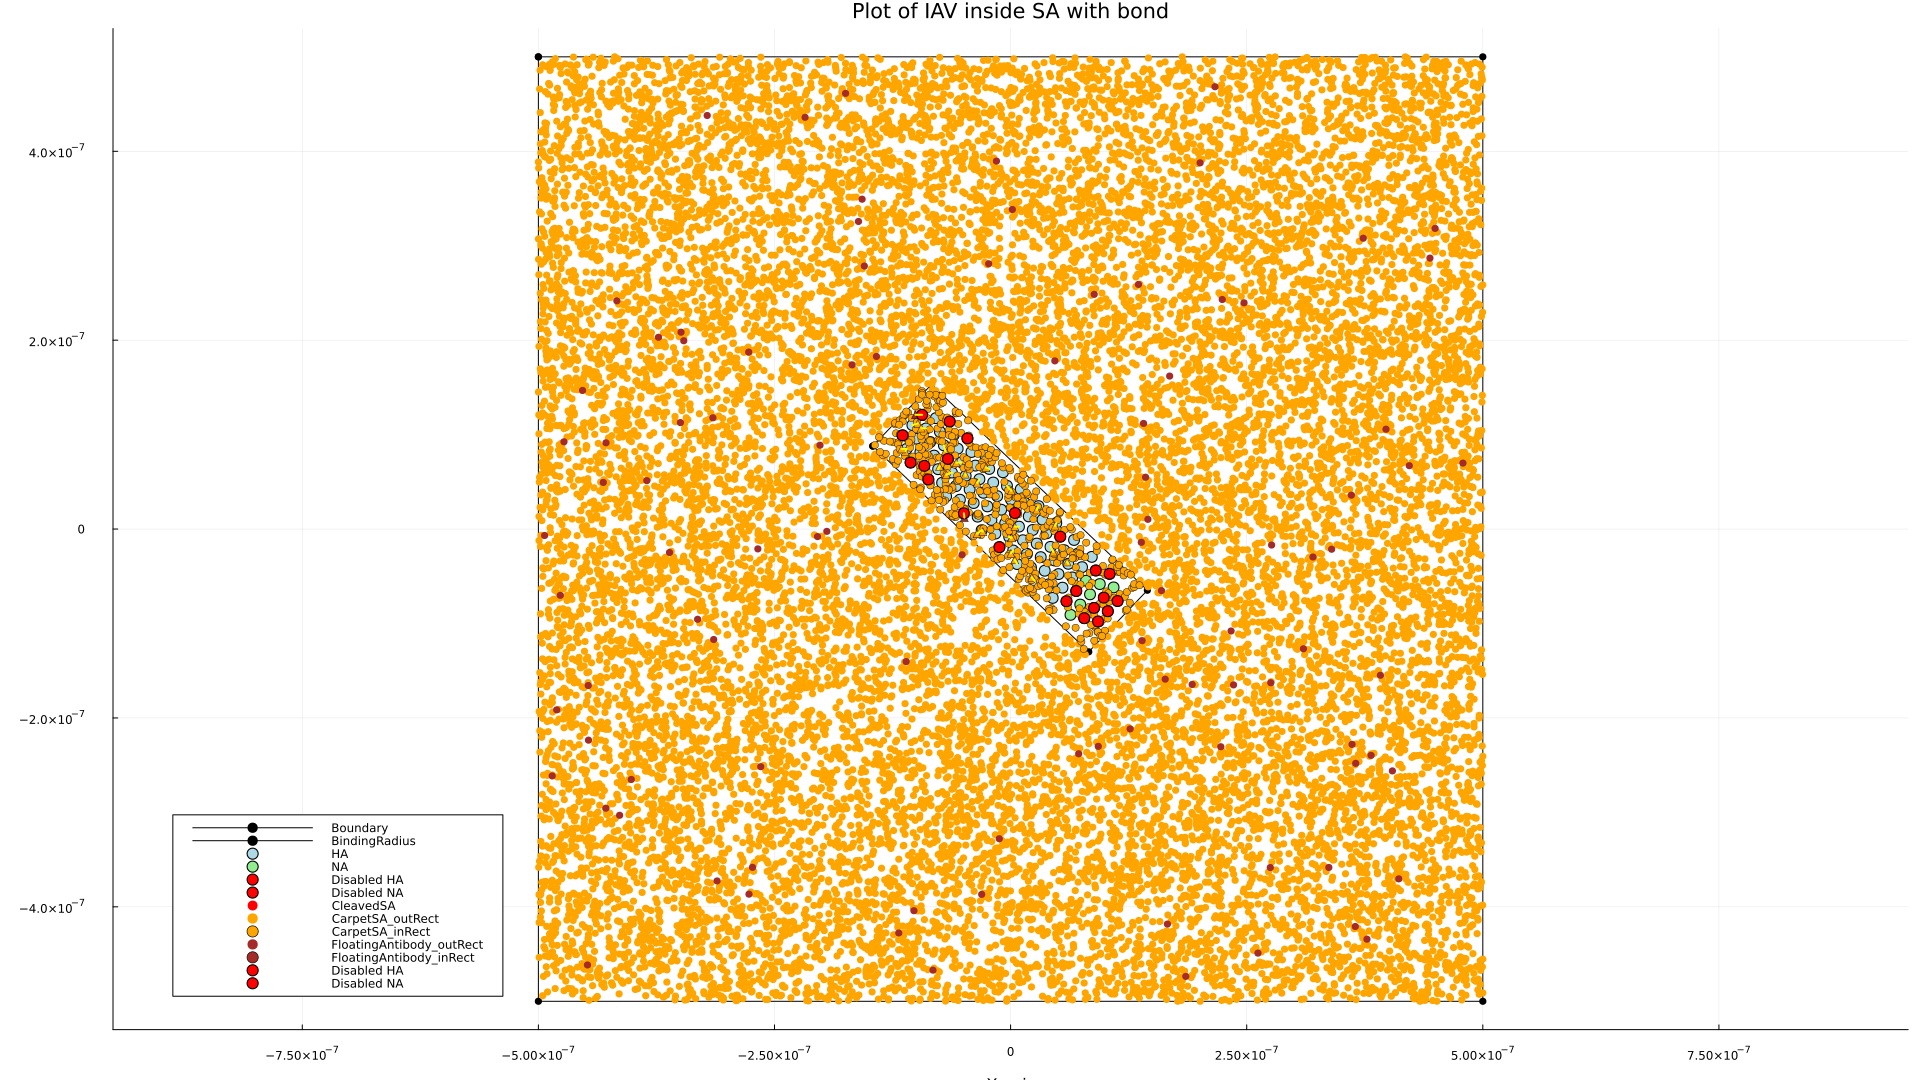

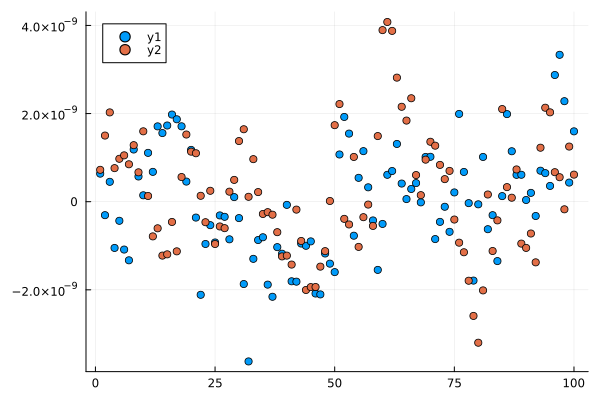

"C:\\Users\\yuang\\temp\\rex_iav_diffusion\\setup3,0.5allowbreakdot.png"

In [16]:
# Plot analysis
display(ResultPlots[size(ResultPlots, 1)])
# savefig(ResultPlots[size(ResultPlots, 1)],"setup3,0.5allowbreak.png")
p = scatter(1:size(DMOVEMENT, 2), DMOVEMENT[1, :])
scatter!(1:size(DMOVEMENT, 2), DMOVEMENT[2, :])
# scatter!(1:size(DMOVEMENT, 2), DMOVEMENT[3, :])
display(p)
savefig(p,"setup3,0.5allowbreakdot.png")
# @show DMOVEMENT
# @show DMOVEMENT[2, :]
# @show DMOVEMENT[3, :]